# EDA for Data Analysis Project by Tianyi, Martine and Rami

## Project Description
Our project aims to track NBA players' movements (i.e what teams they played for) while tracking the year and their scoring performances. 
To do so, we collected data from https://www.basketball-reference.com ranging from 1995 to 2024 and used a code (thanks to Professor Bouyahya) to merge the tables and only keep the columns that are pertinent to our project. You can find this code in the repository.

# Part 1 - Codes and functions

In [26]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import plotly.express as px

In [27]:
df = pd.read_csv("nba_player_stats_C_Rami.csv")
df

,Player,Team,Points,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Trp-Dbl,Season
0,Luka Dončić,DAL,2370.0,PG,70.0,70.0,2624.0,804.0,1652.0,0.487,...,59.0,588.0,647.0,686.0,99.0,38.0,282.0,149.0,21.0,2024
1,Shai Gilgeous-Alexander,OKC,2254.0,PG,75.0,75.0,2553.0,796.0,1487.0,0.535,...,65.0,350.0,415.0,465.0,150.0,67.0,162.0,184.0,0.0,2024
2,Giannis Antetokounmpo,MIL,2222.0,PF,73.0,73.0,2567.0,837.0,1369.0,0.611,...,196.0,645.0,841.0,476.0,87.0,79.0,250.0,210.0,10.0,2024
3,Jalen Brunson,NYK,2212.0,PG,77.0,77.0,2726.0,790.0,1648.0,0.479,...,43.0,235.0,278.0,519.0,70.0,13.0,186.0,144.0,0.0,2024
4,Nikola Jokić,DEN,2085.0,C,79.0,79.0,2737.0,822.0,1411.0,0.583,...,223.0,753.0,976.0,708.0,108.0,68.0,237.0,194.0,25.0,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17808,Yinka Dare,NJN,0.0,C,1.0,0.0,3.0,0.0,1.0,0.000,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1995
17809,Tom Hovasse,ATL,0.0,SF,2.0,0.0,4.0,0.0,1.0,0.000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1995
17810,Rich King,SEA,0.0,C,2.0,0.0,6.0,0.0,2.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1995
17811,Derrick Phelps,SAC,0.0,PG,3.0,0.0,5.0,0.0,1.0,0.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1995


In [28]:
df.shape

(17813, 29)

This function will get a player's data and put it into one smaller table (the player name is inputted by the user)

In [29]:
def get_player_stats(player_name, df):

    # Filter the dataset for the given player
    player_data = df[df['Player'].str.lower() == player_name.lower()]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return None
    
    # Sort by season
    player_data = player_data.sort_values(by='Season', ascending=True)
    
    # Print the table
    print(player_data)

    #Plotting the data
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=player_data['Season'], y=player_data['Points'], label=player_name)
    plt.xlabel("Season")
    plt.ylabel("Total Points")
    plt.title(f"Points per Season for {player_name}")
    plt.xticks(player_data['Season'].unique())
    plt.grid(True)
    plt.show()

This function will map the different cities that a player has played for, with the marker sizes being bigger for the cities with the best scoring performance for the player. To do so, we needed to sum up the total points scored in each city and scale marker size so that cities where the player scored more points have larger markers.

In [30]:
#Dictionary mapping NBA teams to cities and their approximate coordinates
team_city_mapping = {
    "ATL": ("Atlanta", -84.3885, 33.7501),
    "BOS": ("Boston", -71.0589, 42.3601),
    "BKN": ("Brooklyn", -73.9442, 40.6782),
    "CHA": ("Charlotte", -80.8431, 35.2271),
    "CHI": ("Chicago", -87.6298, 41.8781),
    "CLE": ("Cleveland", -81.6944, 41.4993),
    "DAL": ("Dallas", -96.7970, 32.7767),
    "DEN": ("Denver", -104.9903, 39.7392),
    "DET": ("Detroit", -83.0458, 42.3314),
    "GSW": ("San Francisco", -122.4194, 37.7749),
    "HOU": ("Houston", -95.3698, 29.7604),
    "IND": ("Indianapolis", -86.1581, 39.7684),
    "LAC": ("Los Angeles", -118.2437, 34.0522),
    "LAL": ("Los Angeles", -118.2437, 34.0522),
    "MEM": ("Memphis", -90.0490, 35.1495),
    "MIA": ("Miami", -80.1918, 25.7617),
    "MIL": ("Milwaukee", -87.9065, 43.0389),
    "MIN": ("Minneapolis", -93.2650, 44.9778),
    "NOP": ("New Orleans", -90.0715, 29.9511),
    "NYK": ("New York", -74.0060, 40.7128),
    "OKC": ("Oklahoma City", -97.5164, 35.4676),
    "ORL": ("Orlando", -81.3792, 28.5383),
    "PHI": ("Philadelphia", -75.1652, 39.9526),
    "PHX": ("Phoenix", -112.0740, 33.4484),
    "POR": ("Portland", -122.6765, 45.5152),
    "SAC": ("Sacramento", -121.4944, 38.5816),
    "SAS": ("San Antonio", -98.4936, 29.4241),
    "TOR": ("Toronto", -79.3832, 43.6532),
    "UTA": ("Salt Lake City", -111.8910, 40.7608),
    "WAS": ("Washington", -77.0369, 38.9072)
}

def plotcities_plt(player_name, df):
    player_data = df[df['Player'].str.lower() == player_name.lower()]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return
    
    #Grouping points by team
    points_by_team = player_data.groupby("Team")["Points"].sum().reset_index()
    
    #Retrieving city coordinates and points
    cities = []

    for i, row in points_by_team.iterrows():
        team, points = row["Team"], row["Points"]
        if team in team_city_mapping:
            city, lon, lat = team_city_mapping[team]
            cities.append((city, lon, lat, points))

    if not cities:
        print(f"No mapped cities found for {player_name}.")
        return

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(cities, columns=['City', 'Longitude', 'Latitude', 'Points'])
    gdf['geometry'] = [Point(xy) for xy in zip(gdf['Longitude'], gdf['Latitude'])]
    gdf = gdf.set_geometry('geometry').set_crs(epsg=4326).to_crs(epsg=3857)

    #Scaling marker size based on points scored
    min_size, max_size = 50, 500  
    gdf['Marker Size'] = min_size + (gdf['Points'] - gdf['Points'].min()) / (
        gdf['Points'].max() - gdf['Points'].min()) * (max_size - min_size)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, markersize=gdf['Marker Size'], label=player_name)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"Cities {player_name} Played For", fontsize=16)
    ax.set_axis_off()
    plt.show()


def plotcities_plotly(player_name, df):
    player_data = df[df['Player'].str.lower() == player_name.lower()]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return
    
    # Grouping points by team
    points_by_team = player_data.groupby("Team")["Points"].sum().reset_index()
    
    # Retrieving city coordinates and points
    cities = []
    for _, row in points_by_team.iterrows():
        team, points = row["Team"], row["Points"]
        if team in team_city_mapping:
            city, lon, lat = team_city_mapping[team]
            cities.append({"City": city, "Longitude": lon, "Latitude": lat, "Points": points})
    
    if not cities:
        print(f"No mapped cities found for {player_name}.")
        return
    
    # Convert to DataFrame
    gdf = pd.DataFrame(cities)
    
    # Scaling marker size based on points scored
    min_size, max_size = 10, 50  # Adjust marker size range
    gdf['Marker Size'] = min_size + (gdf['Points'] - gdf['Points'].min()) / (
        gdf['Points'].max() - gdf['Points'].min()) * (max_size - min_size)
    
    # Plot with Plotly
    fig = px.scatter_mapbox(
        gdf,
        lat="Latitude",
        lon="Longitude",
        size="Marker Size",
        hover_name="City",
        hover_data={"Points": True, "Latitude": False, "Longitude": False},
        size_max=max_size,
        zoom=3,
        title=f"Cities {player_name} Played For"
    )
    
    fig.update_layout(
        mapbox_style="open-street-map",
        margin={"r":0,"t":40,"l":0,"b":0}
    )
    
    fig.show()


# df = px.data.gapminder().query("year == 2007")
# fig = px.scatter_geo(df, locations="iso_alpha", size="pop", hover_name="country", title="Population by country (in 2007)")
# fig.show()
# df


# Part 2 - Usage and Results of Functions 

### Section 1 : using ```matplotlib```

             Player Team  Points Pos     G    GS      MP     FG     FGA  \
12584  LeBron James  CLE  1654.0  SG  79.0  79.0  3122.0  622.0  1492.0   
11992  LeBron James  CLE  2175.0  SF  80.0  80.0  3388.0  795.0  1684.0   
11428  LeBron James  CLE  2478.0  SF  79.0  79.0  3361.0  875.0  1823.0   
10911  LeBron James  CLE  2132.0  SF  78.0  78.0  3190.0  772.0  1621.0   
10315  LeBron James  CLE  2250.0  SF  75.0  74.0  3027.0  794.0  1642.0   
9732   LeBron James  CLE  2304.0  SF  81.0  81.0  3054.0  789.0  1613.0   
9153   LeBron James  CLE  2258.0  SF  76.0  76.0  2966.0  768.0  1528.0   
8527   LeBron James  MIA  2111.0  SF  79.0  79.0  3063.0  758.0  1485.0   
7975   LeBron James  MIA  1683.0  SF  62.0  62.0  2326.0  621.0  1169.0   
7402   LeBron James  MIA  2036.0  PF  76.0  76.0  2877.0  765.0  1354.0   
6790   LeBron James  MIA  2089.0  PF  77.0  77.0  2902.0  767.0  1353.0   
6139   LeBron James  CLE  1743.0  SF  69.0  69.0  2493.0  624.0  1279.0   
5560   LeBron James  CLE 

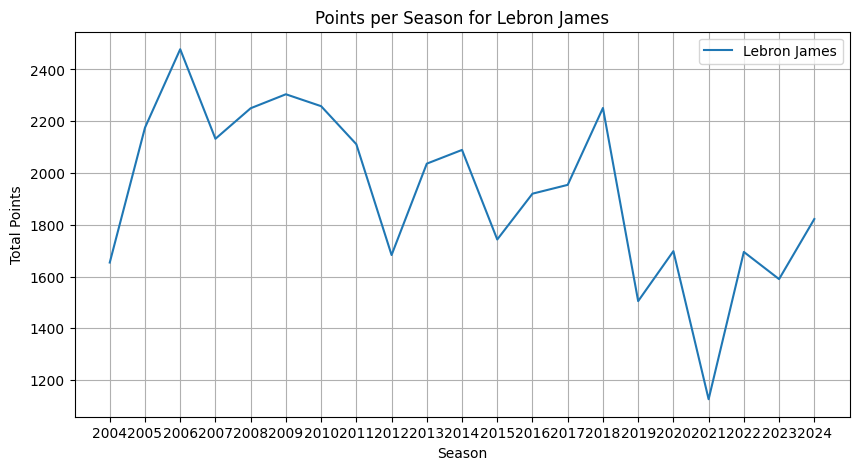

C:\Users\tiany\AppData\Local\Temp\ipykernel_18696\988709701.py:60: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



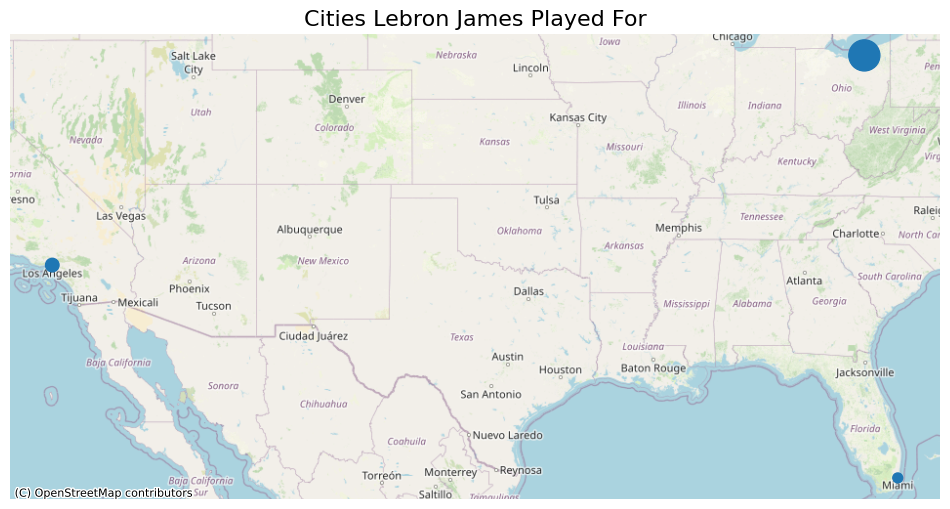

In [31]:
player_name = input("Enter player name: ")
get_player_stats(player_name, df)
plotcities_plt(player_name, df)

In [32]:
plotcities_plotly(player_name,df)

C:\Users\tiany\AppData\Local\Temp\ipykernel_18696\988709701.py:111: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Section 2 : ```Plotly```